# Проект Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

###### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.



###### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

*Признаки*
* `BeginDate` — Дата начала пользования услугами
* `Type` — тип оплаты: ежемесячный, годовой
* `PaperlessBilling` — Электронный документ об оплате
* `PaymentMethod` — Способ оплаты
* `MonthlyCharges` — Ежемесячные траты на услуги
* `TotalCharges` — Всего потрачено денег на услуги
* `EndDate` — Дата окончания пользования услугами
* `TotalDays` — Сколько пользователь пользовался услугами
* `Gender` — Пол клиента
* `SeniorCitizen` — Наличие пенсионного статуса по возрасту
* `Partner` — Наличие супруга(и)
* `Dependents` — Наличие иждивенцев
* `InternetService` — Способ передачи
* `OnlineSecurity` — Блокировка небезопасных сайтов 
* `OnlineBackup` — Облачное хранилище
* `DeviceProtection` — Интернет-безопасность (антивирус)
* `TechSupport` — Выделенная линия технической поддержки
* `StreamingTV` — Стриминговое телевидение 
* `StreamingMovies` — Онлайн-кинотеатр  
* `MultipleLines` — Наличие возможности ведения параллельных линий во время звонка
 
*Целевой признак*
* `ServiceCancellation` — Отказ от услуг 

###### План работы

- Загрузка и подготовка данных
    - Вывод
- Исследовательский анализ данных
- Подготовка данных для моделей
- Обучение моделей
    - LogisticRegression
    - RandomForestClassifier
    - CatBoostClassifier
    - Тестирование
    - Важность факторов
    - Матрицу ошибок
- Общий вывод


## Загрузка и подготовка данных

In [1]:
!pip install phik

In [2]:
!pip install -U scikit-learn

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import itertools
from phik import resources, report
from scipy.stats import chi2_contingency
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.model_selection import (
    GridSearchCV, 
    cross_val_score,
    train_test_split
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    make_scorer,
    roc_curve,
    roc_auc_score
)


import warnings
RANDOM_STATE = 50623

In [4]:
data_contract = pd.read_csv('/datasets/contract_new.csv')
data_personal = pd.read_csv('/datasets/personal_new.csv')
data_internet = pd.read_csv('/datasets/internet_new.csv')
data_phone = pd.read_csv('/datasets/phone_new.csv')

In [5]:
datasets = [data_contract, data_personal, data_internet,data_phone]
for dataset in datasets:
  display(dataset.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [6]:
for dataset in datasets:
  display(dataset.describe(include='all'))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,0254-FNMCI,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,0254-FNMCI,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0254-FNMCI,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,0254-FNMCI,No
freq,1,3390


In [7]:
for dataset in datasets:
  display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

In [8]:
for dataset in datasets:
  display(dataset.shape)

(7043, 8)

(7043, 5)

(5517, 8)

(6361, 2)

In [9]:
data_contract = data_contract.rename(columns={'customerID': 'CustomerID'})
data_contract.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [10]:
data_personal = data_personal.rename(columns={'customerID': 'CustomerID'})
data_personal = data_personal.rename(columns={'gender': 'Gender'})
data_personal.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [11]:
data_internet = data_internet.rename(columns={'customerID': 'CustomerID'})
data_internet.head()

,CustomerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
data_phone = data_phone.rename(columns={'customerID': 'CustomerID'})
data_phone.head()

,CustomerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


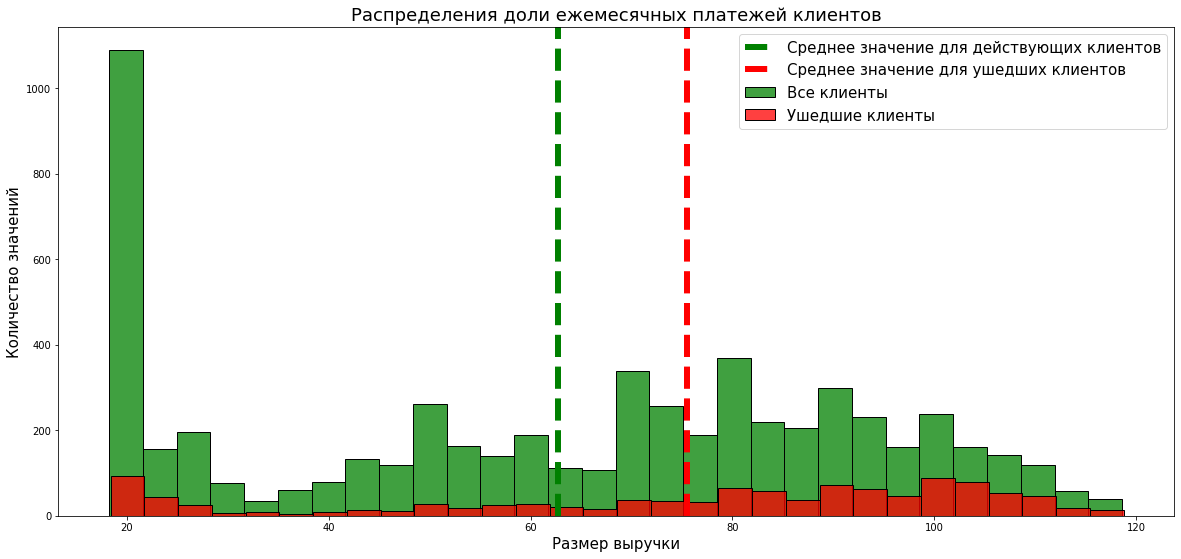

In [13]:
# Посмотрим на график ежемесячной оплаты и соотнесем его с уходом клиентов
f, axes = plt.subplots(1, 1, figsize=(20, 9))
axes.set_title('Распределения доли ежемесячных платежей клиентов', fontsize=18)
axes.set_ylabel('Количество значений', fontsize=15)
sns.histplot(data_contract[data_contract['EndDate'] == 'No']['MonthlyCharges'], bins=30, color = 'green')
sns.histplot(data_contract[data_contract['EndDate'] != 'No']['MonthlyCharges'], bins = 30, color = 'red')
axes.set_xlabel('Размер выручки', fontsize=15)
plt.axvline(data_contract[data_contract['EndDate'] == 'No']['MonthlyCharges'].mean(), 0, color = 'green', linestyle='--', linewidth = 6)
plt.axvline(data_contract[data_contract['EndDate'] != 'No']['MonthlyCharges'].mean(), 0, color = 'red', linestyle='--', linewidth = 6)
axes.legend(labels=["Среднее значение для действующих клиентов","Среднее значение для ушедших клиентов", 
                    "Все клиенты","Ушедшие клиенты"], fontsize=15);

Из построенного графика наблюдаем, что от оператора уходят клиенты с большим среднемесячным платежом

На данном этапе мы загрузили данные, исследовали их. На следующем этапе произведем их предоработку для обучения моделей

Добавим целевой признак **ServiceCancellation**, который будет означать отказался клиент от услуг или нет.

Если значение в столбце **EndDate** равно "No", то значит клиент не ушел и целевой признак равен 0.

Если дата ухода есть, то целевой признак равен 1.

In [14]:
data_contract['ServiceCancellation'] = (data_contract['EndDate'] != 'No').astype(int)
data_contract.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ServiceCancellation
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0


In [15]:
# Заменим все значения "No" в EndDate на дату выгрузки датасета (01.02.2020)
data_contract['EndDate'] = data_contract['EndDate'].replace(['No'], ['2020-02-01'])
data_contract[data_contract['EndDate'] == 'No'].shape[0]
data_contract.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ServiceCancellation
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,0


In [16]:
# Переведем EndDate и BeginDate в формат даты
data_contract['BeginDate'] = pd.to_datetime(data_contract['BeginDate'], format='%Y-%m-%d')
data_contract['EndDate'] = pd.to_datetime(data_contract['EndDate'], format='%Y-%m-%d')
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CustomerID           7043 non-null   object        
 1   BeginDate            7043 non-null   datetime64[ns]
 2   EndDate              7043 non-null   datetime64[ns]
 3   Type                 7043 non-null   object        
 4   PaperlessBilling     7043 non-null   object        
 5   PaymentMethod        7043 non-null   object        
 6   MonthlyCharges       7043 non-null   float64       
 7   TotalCharges         7043 non-null   object        
 8   ServiceCancellation  7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 495.3+ KB


In [17]:
data_contract['TotalCharges'] = data_contract['TotalCharges'].replace([' '], 0)

In [18]:
data_contract['MonthlyCharges'] = data_contract['MonthlyCharges'].astype('int')
data_contract['TotalCharges'] = data_contract['TotalCharges'].astype('float')

In [19]:
data_contract['TotalCharges'] = data_contract['TotalCharges'].astype('int')

In [20]:
#Заведем новый столбец TotalDays, который будет означать, сколько пользователь пользовался услугами
data_contract['TotalDays'] = (data_contract['EndDate'] - data_contract['BeginDate']).dt.days

In [21]:
#Приведем столбец TotalCharges к числовому.
data_contract['TotalCharges'] = pd.to_numeric(data_contract['TotalCharges'], errors ='coerce')
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CustomerID           7043 non-null   object        
 1   BeginDate            7043 non-null   datetime64[ns]
 2   EndDate              7043 non-null   datetime64[ns]
 3   Type                 7043 non-null   object        
 4   PaperlessBilling     7043 non-null   object        
 5   PaymentMethod        7043 non-null   object        
 6   MonthlyCharges       7043 non-null   int64         
 7   TotalCharges         7043 non-null   int64         
 8   ServiceCancellation  7043 non-null   int64         
 9   TotalDays            7043 non-null   int64         
dtypes: datetime64[ns](2), int64(4), object(4)
memory usage: 550.4+ KB


In [22]:
data_contract[data_contract['TotalCharges'].isnull()]

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ServiceCancellation,TotalDays


Видно, что все эти клиенты подключены всего 1 день, заполним пропуски в `TotalCharges` на 0

In [23]:
data_contract['TotalCharges'] = data_contract['TotalCharges'].fillna(0)
data_contract['TotalCharges'].isnull().sum()

0

In [24]:
data_contract.loc[:,'MonthlyCharges'] = pd.to_numeric(data_contract['MonthlyCharges'], errors='raise')
#В режиме **raise** ошибок не появилось, значит все данные корректные. Проверка
data_contract['MonthlyCharges'].head()

0    29
1    56
2    53
3    42
4    70
Name: MonthlyCharges, dtype: int64

In [25]:
#Объединим все данные в один датафрейм
data_full = data_contract \
    .merge(data_personal, how='left', on='CustomerID') \
    .merge(data_internet, how='left', on='CustomerID') \
    .merge(data_phone, how='left', on='CustomerID') 


In [26]:
#Проверим, что все значения CustomerID` уникальные
data_full['CustomerID'].is_unique

True

In [27]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CustomerID           7043 non-null   object        
 1   BeginDate            7043 non-null   datetime64[ns]
 2   EndDate              7043 non-null   datetime64[ns]
 3   Type                 7043 non-null   object        
 4   PaperlessBilling     7043 non-null   object        
 5   PaymentMethod        7043 non-null   object        
 6   MonthlyCharges       7043 non-null   int64         
 7   TotalCharges         7043 non-null   int64         
 8   ServiceCancellation  7043 non-null   int64         
 9   TotalDays            7043 non-null   int64         
 10  Gender               7043 non-null   object        
 11  SeniorCitizen        7043 non-null   int64         
 12  Partner              7043 non-null   object        
 13  Dependents           7043 non-nul

Пропуски в `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` и `MultipleLines` скорее всего означают, что услуги не подключены. Заменим пропуски на "No"

In [28]:
for column in ('InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'):
    data_full[column] = data_full[column].fillna('No')

In [29]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CustomerID           7043 non-null   object        
 1   BeginDate            7043 non-null   datetime64[ns]
 2   EndDate              7043 non-null   datetime64[ns]
 3   Type                 7043 non-null   object        
 4   PaperlessBilling     7043 non-null   object        
 5   PaymentMethod        7043 non-null   object        
 6   MonthlyCharges       7043 non-null   int64         
 7   TotalCharges         7043 non-null   int64         
 8   ServiceCancellation  7043 non-null   int64         
 9   TotalDays            7043 non-null   int64         
 10  Gender               7043 non-null   object        
 11  SeniorCitizen        7043 non-null   int64         
 12  Partner              7043 non-null   object        
 13  Dependents           7043 non-nul

### Вывод

* Добавил целевой признак `ServiceCancellation`, который будет означать отказался клиент от услуг или нет.
*  Заменил все значения "No" в `EndDate` на дату выгрузки датасета (01.02.2020)
* `BeginDate` и `EndDate`перевел в формат даты
* Заведил новый столбец `TotalDays`, который будет означать, сколько пользователь пользовался услугами
* Приведел столбец `TotalCharges` к числовому.
* Объединил все данные в один датафрейм `data_full`
* Переименовал customerID -> CustomerID, gender -> Gender
* Установил `CustomerID` в качестве индекса
* Пропуски в `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` и `MultipleLines` заменил на "No"


## Исследовательский анализ данных


In [30]:
num_col = ['MonthlyCharges', 'TotalCharges', 'TotalDays']
cat_col = [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'Gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies', 
    'MultipleLines',
]


Покажем наглядно влияние фичей на целевой признак - факт ухода клиента.

Для этого можно воспользоваться функцией chi2_contingency для определения статистической значимости различий ушедших и оставшихся клиентов.
Создадим функцию, принимающую на вход столбец, по которому будем считать корреляцию.

Функция мержит таблицу с количеством ушедших и оставшихся клиентов, сгруппированных по нужной фиче, вычисляет значение статистики и делает вывод о влиянии фичи на уход клиента из компании.

In [31]:
def merge_chi2(column):
    table_for_merge_1 = data_full.groupby(column, as_index = False)['ServiceCancellation'].sum()
    table_for_merge_2 = data_full.groupby(column, as_index = False)['CustomerID'].count()
    merge_table = table_for_merge_1.merge(table_for_merge_2, on = column)
    merge_table.rename(columns = {'CustomerID':'all'}, inplace = True)
    merge_table['RemainingClients'] = merge_table['all'] - merge_table['ServiceCancellation']
    merge_table = merge_table.drop('all', axis = 1)
        
    stat, p_value, dof, expected = chi2_contingency(merge_table[['ServiceCancellation', 'RemainingClients']])
      
    return merge_table, p_value

Для наглядности добавил проверку гипотез.

Где:

* нулевая гипотеза: признак не связан с оттоком клиентов;

* альтернативная: признак связан с оттоком клиентов.

* Примем значение порога статистической значимости alpha = 0.05.

* Вызовем функцию для всех категориальных столбцов:

In [32]:
alpha = 0.05

,Type,ServiceCancellation,RemainingClients
0,Month-to-month,407,3468
1,One year,313,1160
2,Two year,381,1314


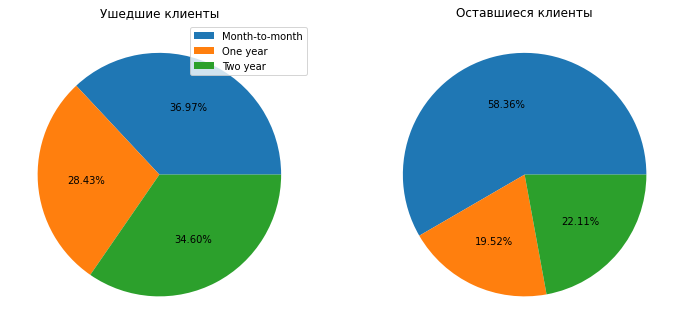

p-значение: 3.065849096341664e-38
Отклоняем нулевую гипотезу


,PaperlessBilling,ServiceCancellation,RemainingClients
0,No,380,2492
1,Yes,721,3450


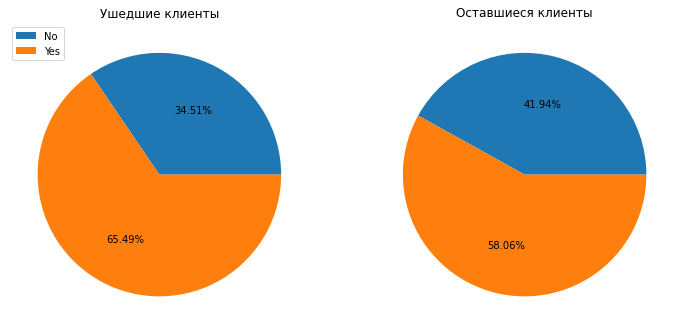

p-значение: 4.846228533723826e-06
Отклоняем нулевую гипотезу


,PaymentMethod,ServiceCancellation,RemainingClients
0,Bank transfer (automatic),317,1227
1,Credit card (automatic),317,1205
2,Electronic check,350,2015
3,Mailed check,117,1495


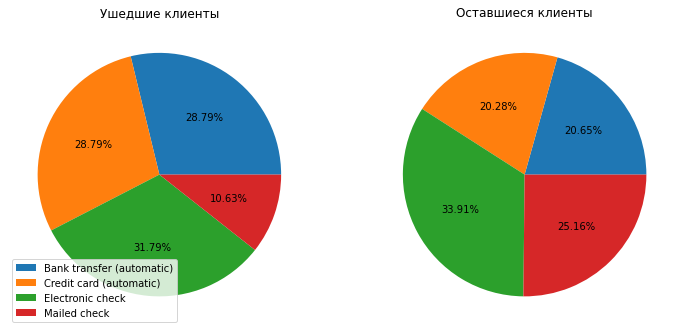

p-значение: 1.7359650541850085e-31
Отклоняем нулевую гипотезу


,Gender,ServiceCancellation,RemainingClients
0,Female,528,2960
1,Male,573,2982


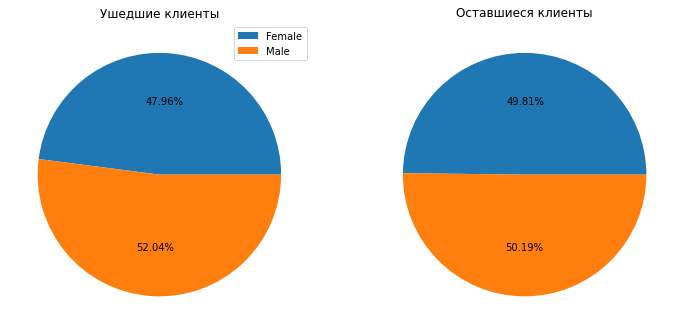

p-значение: 0.2712988931477521
Не получилось отклонить нулевую гипотезу


,SeniorCitizen,ServiceCancellation,RemainingClients
0,0,869,5032
1,1,232,910


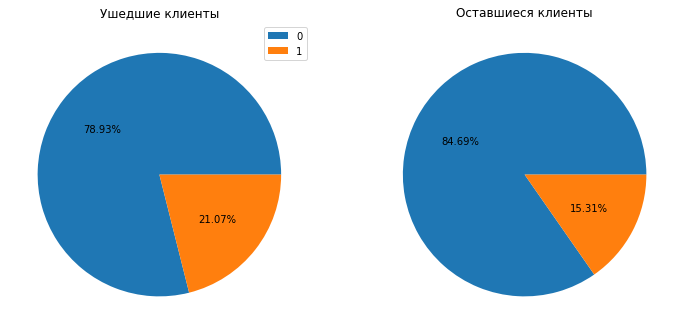

p-значение: 2.4066754883142295e-06
Отклоняем нулевую гипотезу


,Partner,ServiceCancellation,RemainingClients
0,No,382,3259
1,Yes,719,2683


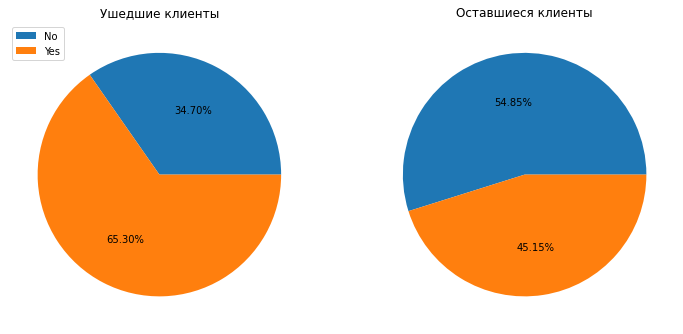

p-значение: 1.5331159930026101e-34
Отклоняем нулевую гипотезу


,Dependents,ServiceCancellation,RemainingClients
0,No,733,4200
1,Yes,368,1742


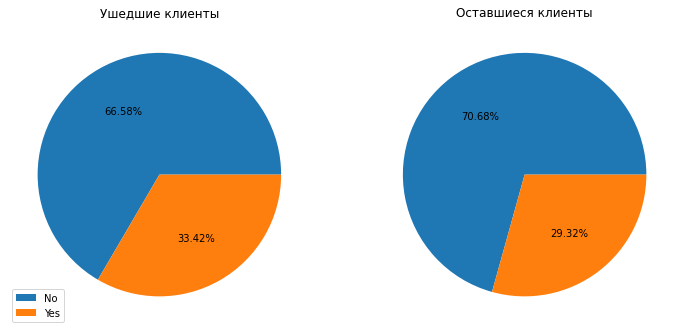

p-значение: 0.006996418239573212
Отклоняем нулевую гипотезу


,InternetService,ServiceCancellation,RemainingClients
0,DSL,346,2075
1,Fiber optic,595,2501
2,No,160,1366


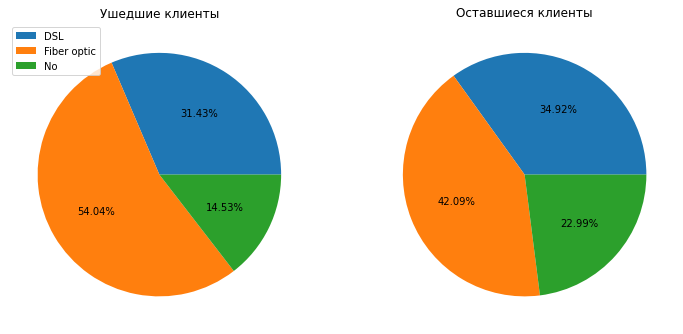

p-значение: 1.1787764842848553e-14
Отклоняем нулевую гипотезу


,OnlineSecurity,ServiceCancellation,RemainingClients
0,No,686,4338
1,Yes,415,1604


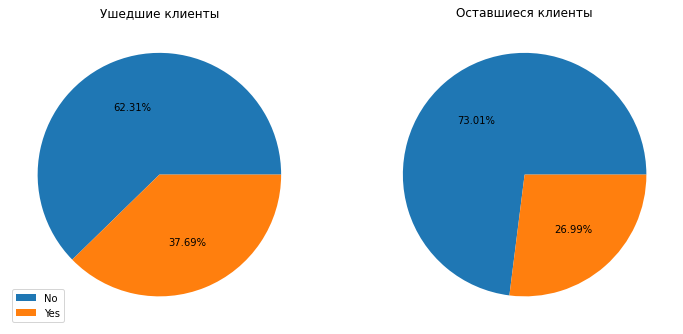

p-значение: 7.260860275182705e-13
Отклоняем нулевую гипотезу


,OnlineBackup,ServiceCancellation,RemainingClients
0,No,541,4073
1,Yes,560,1869


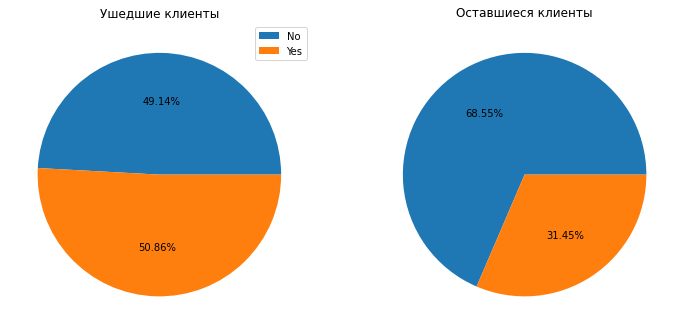

p-значение: 2.3008102924477676e-35
Отклоняем нулевую гипотезу


,DeviceProtection,ServiceCancellation,RemainingClients
0,No,551,4070
1,Yes,550,1872


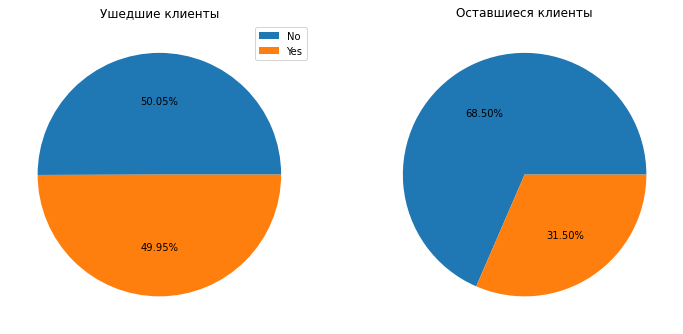

p-значение: 3.742336045663829e-32
Отклоняем нулевую гипотезу


,TechSupport,ServiceCancellation,RemainingClients
0,No,703,4296
1,Yes,398,1646


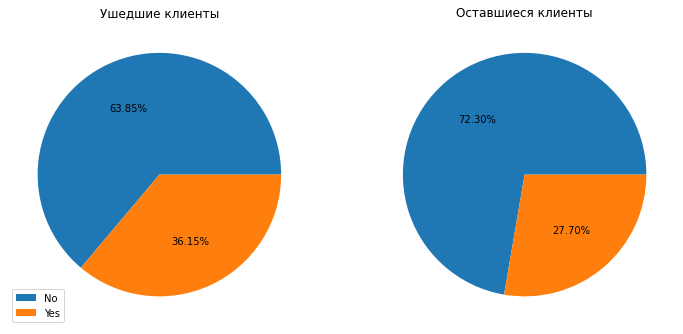

p-значение: 1.7331714072640974e-08
Отклоняем нулевую гипотезу


,StreamingTV,ServiceCancellation,RemainingClients
0,No,517,3819
1,Yes,584,2123


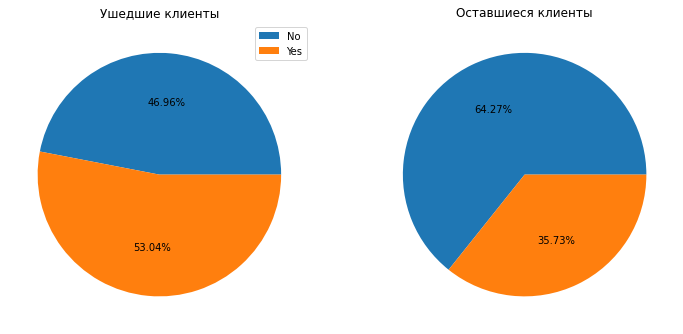

p-значение: 2.948361091032949e-27
Отклоняем нулевую гипотезу


,StreamingMovies,ServiceCancellation,RemainingClients
0,No,495,3816
1,Yes,606,2126


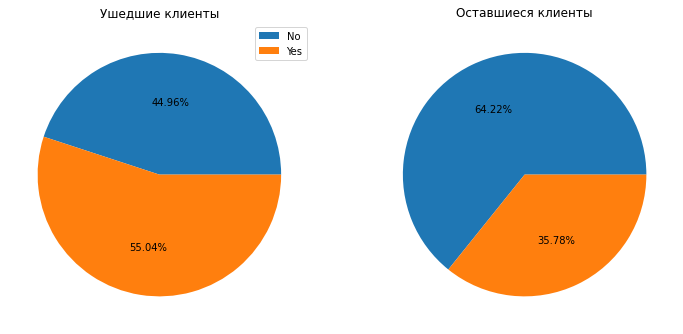

p-значение: 2.9992779995344396e-33
Отклоняем нулевую гипотезу


,MultipleLines,ServiceCancellation,RemainingClients
0,No,423,3649
1,Yes,678,2293


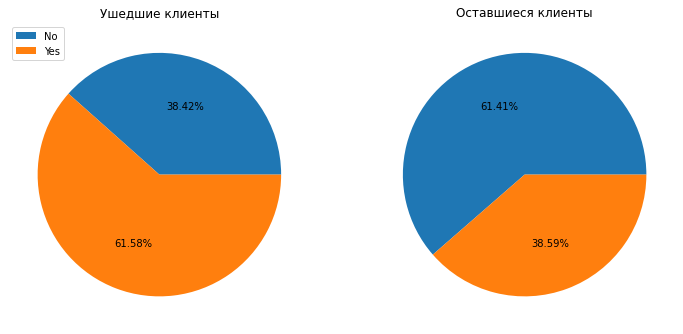

p-значение: 1.7332783467022427e-45
Отклоняем нулевую гипотезу


In [33]:
for i in cat_col:
    table_on_chi2, p_value = merge_chi2(i)
    display(table_on_chi2)
    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 2, 1)
    plt.pie(table_on_chi2['ServiceCancellation'], autopct='%1.2f%%')
    plt.legend(labels=table_on_chi2[i], loc='best')
    plt.title('Ушедшие клиенты')
   
    
    plt.subplot(1, 2, 2)
    plt.pie(table_on_chi2['RemainingClients'], autopct='%1.2f%%')
    plt.title('Оставшиеся клиенты')
    plt.show()
    print('p-значение:', p_value)
    if p_value < alpha:
        print('Отклоняем нулевую гипотезу')
    else:
        print('Не получилось отклонить нулевую гипотезу')

### Вывод


Из таблицы способа оплаты мы видим, что больше всего уходят клиенты с оплатой помесячно.

Из таблиц способов расчета и способов оплаты - больше уходят клиентов с безналичной оплатой по электронным платежам.

Из таблицы наличия супруга (супруги) - больше уходят одиночки.

Из таблицы наличия иждивенцев - больше уходят одиночки.

Из таблицы пенсионного статуса - больше уходят непенсионного возраста.

Из таблицы интернета - больше всего уходят подключенные по оптики (возможно данное подключение дорогое либо качество услуг не устраивает).

Из таблицы подключенных услуг онлайн защиты (фаервола, антивируса) - больше уходят не пользующиеся данной услугой.

Из таблицы подключенных услуг онлайн сохранения - больше уходят не пользующиеся данной услугой.

Из таблицы подключенных услуг DeviceProtection - больше уходят не пользующиеся данной услугой.

Из таблицы подключенных услуг TechSupport - больше уходят не пользующиеся данной услугой.

Из таблицы подключенных услуг StreamingTV - больше уходят не пользующиеся данной услугой.

Из таблицы подключенных услуг StreamingMovies - больше уходят не пользующиеся данной услугой.

Можно сконструировать социальный портрет абонента с высоким риском отказа от услуг компании:

это абонент, не состоящий в браке, не имеющий иждивенцев (детей, престарелых родителей, инвалидов), не достигший пенсионного возраста, заключивший договор недавно, оплачивающий услуги с безналичной оплатой электронными чеками помесячно, имеющий подключение по оптоволоконной связи и не подключающий услуги онлайн-защиты, не пользующийся предлагаемыми дополнительными услугами связи.

In [34]:
del data_full['BeginDate'], data_full['EndDate'], data_full['CustomerID']

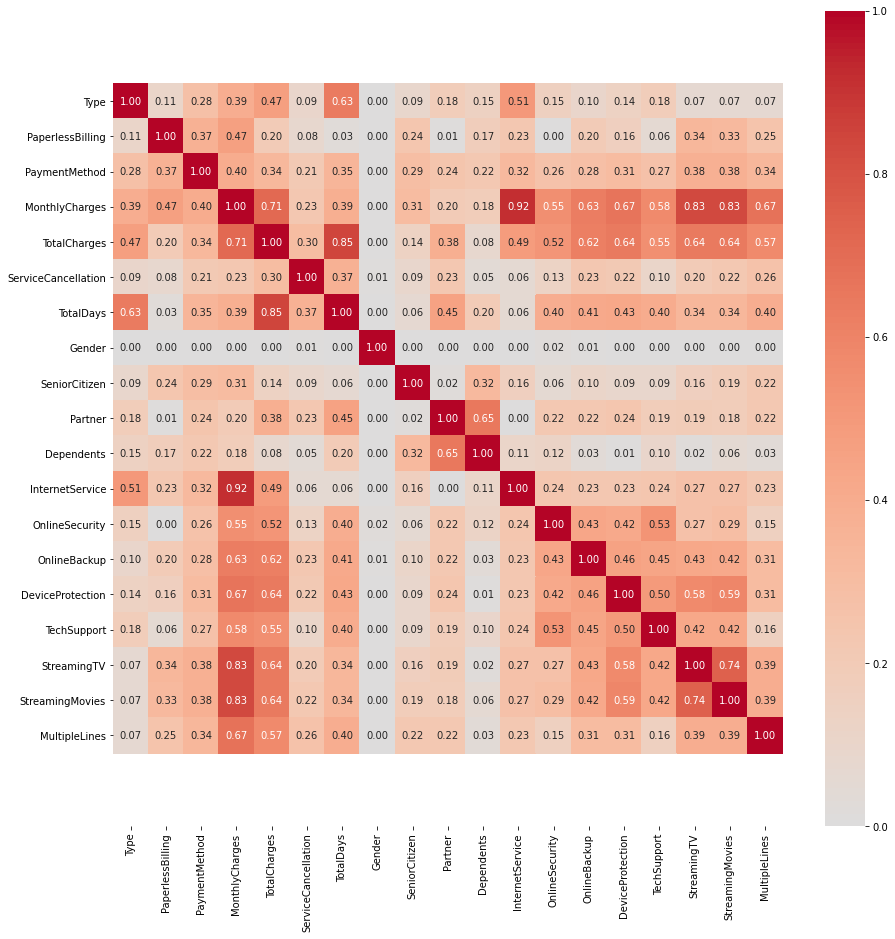

In [35]:
interval_cols=['MonthlyCharges', 'TotalCharges', 'TotalDays']
_ = plt.figure(figsize=(15,15))
sns.heatmap(data_full.phik_matrix(interval_cols=interval_cols), ax=plt.gca(),center=0,cmap='coolwarm', annot=True, fmt='.2f', vmin=0,vmax=1, square=True)
plt.axis('equal');

In [36]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Type                 7043 non-null   object
 1   PaperlessBilling     7043 non-null   object
 2   PaymentMethod        7043 non-null   object
 3   MonthlyCharges       7043 non-null   int64 
 4   TotalCharges         7043 non-null   int64 
 5   ServiceCancellation  7043 non-null   int64 
 6   TotalDays            7043 non-null   int64 
 7   Gender               7043 non-null   object
 8   SeniorCitizen        7043 non-null   int64 
 9   Partner              7043 non-null   object
 10  Dependents           7043 non-null   object
 11  InternetService      7043 non-null   object
 12  OnlineSecurity       7043 non-null   object
 13  OnlineBackup         7043 non-null   object
 14  DeviceProtection     7043 non-null   object
 15  TechSupport          7043 non-null   object
 16  Stream

In [37]:
del data_full['StreamingTV'] ,data_full['StreamingMovies'],data_full['InternetService']

In [38]:
# Рассмотррим матрицу корреляции
data_full.corr()['ServiceCancellation'].sort_values(ascending=False)

ServiceCancellation    1.000000
MonthlyCharges         0.154373
SeniorCitizen          0.056724
TotalCharges           0.052173
TotalDays              0.016578
Name: ServiceCancellation, dtype: float64

In [39]:
data_full[num_col].corr()

,MonthlyCharges,TotalCharges,TotalDays
MonthlyCharges,1.000000,0.630453,0.220056
TotalCharges,0.630453,1.000000,0.821746
TotalDays,0.220056,0.821746,1.000000


In [40]:
del data_full['TotalCharges']
num_col = ['MonthlyCharges', 'TotalDays']

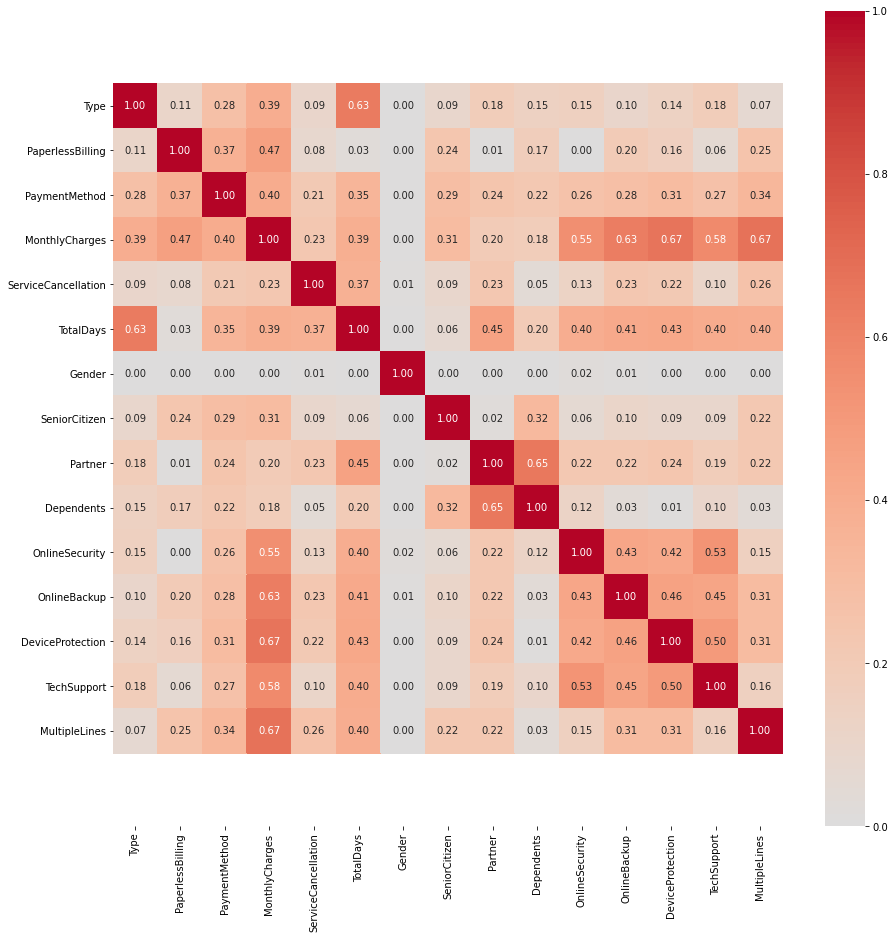

In [41]:
interval_cols=['MonthlyCharges', 'TotalDays']
_ = plt.figure(figsize=(15,15))
sns.heatmap(data_full.phik_matrix(interval_cols=interval_cols), ax=plt.gca(),center=0,cmap='coolwarm', annot=True, fmt='.2f', vmin=0,vmax=1, square=True)
plt.axis('equal');

In [42]:
data_full.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,ServiceCancellation,TotalDays,Gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,MultipleLines
0,Month-to-month,Yes,Electronic check,29,0,31,Female,0,Yes,No,No,Yes,No,No,No
1,One year,No,Mailed check,56,0,1036,Male,0,No,No,Yes,No,Yes,No,No
2,Month-to-month,Yes,Mailed check,53,0,123,Male,0,No,No,Yes,Yes,No,No,No
3,One year,No,Bank transfer (automatic),42,0,1371,Male,0,No,No,Yes,No,Yes,Yes,No
4,Month-to-month,Yes,Electronic check,70,0,153,Female,0,No,No,No,No,No,No,No


In [43]:
num_cols = ['MonthlyCharges', 'TotalDays']
cat_cols = [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'Gender',
    'SeniorCitizen',
    'Partner',
    'Dependents', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport',  
    'MultipleLines',
]


## Подготовка данных для моделей

In [44]:
target = data_full['ServiceCancellation'] 
features = data_full.drop(columns=['ServiceCancellation'] ,axis=1)

In [45]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,
                                                                            random_state=RANDOM_STATE )

In [46]:
print('features_train.shape = ', features_train.shape, 'target_train.shape = ', target_train.shape)
print('features_test.shape = ', features_test.shape, 'target_test.shape = ', target_test.shape)

features_train.shape =  (5282, 14) target_train.shape =  (5282,)
features_test.shape =  (1761, 14) target_test.shape =  (1761,)


In [47]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

In [48]:

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False)

encoder_ohe.fit(features_train_ohe[cat_cols])

features_train_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_ohe[cat_cols])

features_train_ohe = features_train_ohe.drop(cat_cols, axis=1)



features_test_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test_ohe[cat_cols])


# смотрим на результат
features_train_ohe.head()

,MonthlyCharges,TotalDays,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,MultipleLines_Yes
3448,61,153,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4632,19,62,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4534,49,31,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4748,20,671,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1048,19,883,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
scaler=StandardScaler()
scaler.fit(features_train_ohe[num_cols])

features_train_ohe[num_cols]=scaler.transform(features_train_ohe[num_cols])
features_test_ohe[num_cols]=scaler.transform(features_test_ohe[num_cols])

In [50]:
print('features_train.shape = ', features_train_ohe.shape, 'target_train.shape = ', features_train_ohe.shape)
print('features_test.shape = ', features_test_ohe.shape, 'target_test.shape = ', features_test_ohe.shape)

features_train.shape =  (5282, 17) target_train.shape =  (5282, 17)
features_test.shape =  (1761, 29) target_test.shape =  (1761, 29)


In [51]:
features_train_oe = features_train.copy()
features_test_oe = features_test.copy()

In [52]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(features_train_oe[cat_cols])
features_train_oe[cat_cols] = encoder.transform(features_train_oe[cat_cols])
features_test_oe[cat_cols] = encoder.transform(features_test_oe[cat_cols])

In [53]:
scaler=StandardScaler()
scaler.fit(features_train_oe[num_cols])

features_train_oe[num_cols]=scaler.transform(features_train_oe[num_cols])
features_test_oe[num_cols]=scaler.transform(features_test_oe[num_cols])

## Обучение моделей

In [54]:
def plot_roc_curve(target_test, predictions):  
    fpr, tpr, thresholds = roc_curve(target_test, predictions)

    plt.figure(figsize=(11, 5))
    
    plt.plot(fpr, tpr)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC-кривая' )
    
    plt.show()

### LogisticRegression

In [55]:
model = LogisticRegression()

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

logreg = LogisticRegression(solver='lbfgs', n_jobs=-1)



grid_search_lr = GridSearchCV(model, param_grid, cv=5,scoring='roc_auc')


grid_search_lr.fit(features_train_ohe, target_train)
grid_search_lr.best_params_ 
grid_search_lr.best_score_



0.754690666905261

### RandomForestClassifier

In [56]:
modelrfc = RandomForestClassifier()

param_grid = {
    'max_depth': [None] + [i for i in range(2, 7)],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'n_estimators': [10, 50, 100], 
}




grid_search_rf = GridSearchCV(modelrfc, param_grid, cv=5,scoring='roc_auc')


grid_search_rf.fit(features_train_oe, target_train)
grid_search_rf.best_params_ 
grid_search_rf.best_score_



0.8299118062277024

### CatBoostClassifier

In [57]:
modelcat =  CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
param_grid = {
    'learning_rate': [0.1, 0.3],
    'iterations': [50, 100],
    'l2_leaf_reg': [3, 9]
}





grid_search_cat = GridSearchCV(modelcat, param_grid, cv=5,scoring='roc_auc')


grid_search_cat.fit(features_train_oe, target_train)
grid_search_cat.best_params_ 
grid_search_cat.best_score_


0.8750467109290495

### Тестирование

In [58]:
modelclassifier = CatBoostClassifier(**grid_search_cat.best_params_)

model_cat = modelclassifier.fit(features_train_oe, target_train)

0:	learn: 0.5679007	total: 1.82ms	remaining: 181ms
1:	learn: 0.4885530	total: 3.69ms	remaining: 181ms
2:	learn: 0.4411144	total: 4.61ms	remaining: 149ms
3:	learn: 0.4057589	total: 6.02ms	remaining: 145ms
4:	learn: 0.3821204	total: 7.65ms	remaining: 145ms
5:	learn: 0.3656302	total: 9.2ms	remaining: 144ms
6:	learn: 0.3533345	total: 10.8ms	remaining: 144ms
7:	learn: 0.3444684	total: 12.4ms	remaining: 143ms
8:	learn: 0.3385530	total: 13.9ms	remaining: 140ms
9:	learn: 0.3341876	total: 15.5ms	remaining: 139ms
10:	learn: 0.3288673	total: 17ms	remaining: 137ms
11:	learn: 0.3249500	total: 18.4ms	remaining: 135ms
12:	learn: 0.3209821	total: 20ms	remaining: 134ms
13:	learn: 0.3203166	total: 20.8ms	remaining: 128ms
14:	learn: 0.3168715	total: 22.3ms	remaining: 126ms
15:	learn: 0.3141938	total: 23.7ms	remaining: 125ms
16:	learn: 0.3122445	total: 25.1ms	remaining: 123ms
17:	learn: 0.3105447	total: 26.7ms	remaining: 122ms
18:	learn: 0.3092278	total: 28.2ms	remaining: 120ms
19:	learn: 0.3074846	total:

In [59]:
# Проверим на тестовой выборке качество модели 'CatBoostClassifier' 


cb_predict = model_cat.predict(features_test_oe)
prediction_cb = model_cat.predict_proba(features_test_oe)[:,1]

roc_test = roc_auc_score(target_test, prediction_cb)
accuracy_test = accuracy_score(target_test, cb_predict)

print("roc_auc_score_test:", roc_test)
print("accuracy_score_test:", accuracy_test)

roc_auc_score_test: 0.8756662225183212
accuracy_score_test: 0.8926746166950597


### Важность факторов

In [60]:
importances_df = pd.DataFrame(model_cat.feature_importances_, index = features_test_oe.columns, columns=['importances'])
importances_df = importances_df.sort_values(by='importances', ascending=False)
importances_df

,importances
TotalDays,43.819031
Type,12.695890
MonthlyCharges,10.030839
PaymentMethod,7.375844
Partner,5.072306
MultipleLines,4.726070
OnlineBackup,3.956695
Dependents,2.075690
TechSupport,2.066005
DeviceProtection,1.999062


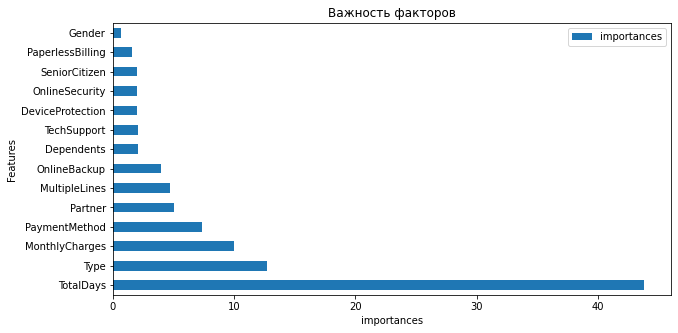

In [61]:
importances_df.plot(kind='barh', figsize=(10, 5), title='Важность факторов')

plt.xlabel("importances")
plt.ylabel("Features")

plt.show()

Достаточно логично, что на лояльность клиентов виляет время использования услуг(`TotalDays`). Как правило, чем дольше ты пользуешься услугами компании, тем меньше вероятность что ты от туда уйдешь. Признак `MonthlyCharges` - месячные траты и `Type` - типы оплаты, тоже достаточно логично, учитывая исследовательский анализ данных проведенных ранее. Затем идут признаки, отвечающие за срок договора, гендер и т.д.

### Матрицу ошибок

Confusion matrix, without normalization
[[1473   28]
 [ 161   99]]


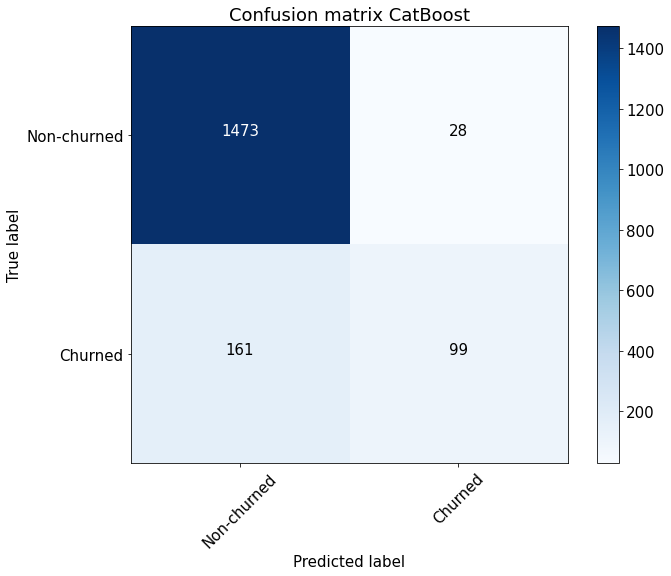

In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(target_test, cb_predict)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix CatBoost')
plt.savefig("conf_matrix.png")
plt.show()

* мы предсказали положительную метку и угадали. Будет относить такие объекты к true positive (TP) группе (true – потому что предсказали мы правильно, а positive – потому что предсказали положительную метку) то есть 1473
* мы предсказали положительную метку, но ошиблись в своём предсказании – false positive (FP) (false, потому что предсказание было неправильным), то есть предсказали FP=28 потверждено  
* мы предсказали отрицательную метку и угадали – true negative (TN=99);
* false negative (FN= 161) мы предсказали отрицательную метку, но ошиблись

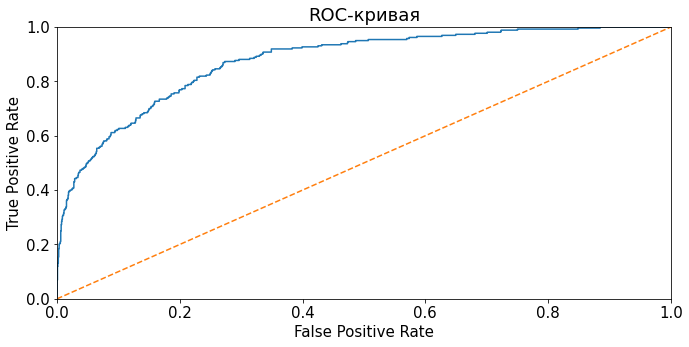

In [63]:
plot_roc_curve(target_test, prediction_cb)

## Общий вывод

* В данной работе проведена работа по предсказанию того, откажется ли клиент от услуг оператора сотовой связи или нет


* Сначала данные были прочитаны и по ним были сделаны предварительные выводы


* После этого была произведена первичная обработка данных - переименованы столбцы, изменены типы данных


* Были добавлены 2 новых столбца - целевой признак `ServiceCancellation`, который означает отказался ли клиент от услуг и `TotalDays`, который обозначает сколько по времени пользователь пользовался услугами

* Удалилено скоррелированные признаки


* После этого был проведен исследовательский анализ данных - проанализированы количественные и категоральные признаки, проведена попытка найти связь между ними и целевым признаком


* Были сделаны следующие выводы: со временем вероятность отказа от услуг снижается и обычно отказывались от услуг те, кто платил больше


* После этого была проведена подготовка данных к обучению моделей: удалены ненужные столбцы,, датафрейм был разделен на обучающую и тестовую выборки, проведено масштабирование количественных признаков и проведен кодировку (OHE для logisticRegression, а OE для RandomForest и CatBoost)


* Затем было проведено оптимизация три гиперпараметров для моделей и оценку на кросс-валидации из `best_score_`


* Лучшую модель **CatBoost** показал ROC-AUC 0.87,были сделаны анализ важности ,матриц ошибок и ROC_curve



## Отчёт

**Ключевые шаги работы над проектом**

- Загрузка и подготовка данных
    - Вывод
- Исследовательский анализ данных
- Подготовка данных для моделей
- Обучение моделей
    - LogisticRegression
    - RandomForestClassifier
    - CatBoostClassifier
    - Тестирование
    - Важность факторов
    - Матрицу ошибок
- Общий вывод


**Анализ соответствия фактической работ запланированным шагам**

Было выполнена : Предобрабодка данных, были изменены типы данных у признаков `BeginDate`, `EndDate` - на datetime и `MonthlyCharges`, `TotalCharges` на float, был добавлен признак  `TotalDays` означающий продолжительность времени использовния услуг заказчика его клиентом на момент выгрузки данных, это позволит посчитать срок для всех клиентов даже тех кто еще продолжает пользоваться, тем самым мы исключаем возможность утечки данных приобучении, далее данные были объеденены. Так же был выделен целевой признак `ServiceCancellation` означающий факт ухода клиента 1- клиент ушел от заказчика 0 - остался. После сборки одного большего дата сета, образовались пропуски так как в 2х датасетах отсутсвует некоторое колличество клиентов, пропуски были заполнены , это важно при кодировании катеоральных признаков.
Перед построения матрицы корреляций были удалены признаки `BeginDate`, `EndDate`,`CustomerID`, также cкоррелориванные признаки `StreamingTV`, `StreamingMovies`,`InternetService` и `TotalCharges`

Все пункты плана были выпонены ,подробнее об этих пунктах написанно в отчете ниже по ходу описания проделланой работы.

**Рефлексия над сложностями и описание путей их решения**

Особых трудностей, входе выполнения работы не возникло, было интересно поработать с этими датасетами.

**Итоговой список признаков для обучения модели,способы их обработки**


*Категориальные признаки*

* `Type` — тип оплаты: ежемесячный, годовой
* `PaperlessBilling` — Электронный документ об оплате
* `PaymentMethod` — Способ оплаты
* `Gender` — Пол клиента
* `SeniorCitizen` — Наличие пенсионного статуса по возрасту
* `Partner` — Наличие супруга(и)
* `Dependents` — Наличие иждивенцев
* `OnlineSecurity` — Блокировка небезопасных сайтов 
* `OnlineBackup` — Облачное хранилище
* `DeviceProtection` — Интернет-безопасность (антивирус)
* `TechSupport` — Выделенная линия технической поддержки
* `MultipleLines` — Наличие возможности ведения параллельных линий во время звонка

*Количественные признаки*
* `MonthlyCharges` — Ежемесячные траты на услуги
* `TotalDays` — Сколько пользователь пользовался 

 
*Целевой признак*
* `ServiceCancellation` — Отказ от услуг 

Проведено масштабирование количественных признаков и кодировка категориальные признаки (OneHotEncoder для logisticRegression, а OrdinalEncoder для RandomForest и CatBoost)

**Краткое описание предобработки данных**

* Была произведена первичная обработка данных - переименованы столбцы, изменены типы данных

* Были добавлены 2 новых столбца - целевой признак `ServiceCancellation`, который означает отказался ли клиент от услуг и `TotalDays`, который обозначает сколько по времени пользователь пользовался услугами

* Было удалено до построения матрицы корреляций признаки ID клиента и даты

* Удалилено скоррелированные признаки


**Сводная таблица исследованных моделей и их метрика на кросс-валидации**

In [64]:
column=['AUC_ROC Метрика']

comparison_tabl = pd.DataFrame(index=['AUC_ROC Метрика'], columns=['LogisticRegression','RandomForestClassifier','CatBoostClassifier'])
comparison_tabl['LogisticRegression'] = grid_search_lr.best_score_
comparison_tabl['RandomForestClassifier'] = grid_search_rf.best_score_
comparison_tabl['CatBoostClassifier'] = grid_search_cat.best_score_


comparison_tabl.T.style.highlight_min(color='yellowgreen',subset=column).highlight_null(null_color='lightgrey').highlight_max(color='coral',subset=column)


,AUC_ROC Метрика
LogisticRegression,0.754691
RandomForestClassifier,0.829912
CatBoostClassifier,0.875047


**Лучшая модель**

Лучшая модель CatBoostClassifier показал 0.87 метрику на кросс-валидации, с гиперпараметрами {'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.3}, при помощью GridSearchCV, также была сделано  ROC_curve

**Итоговая метрика на test (AUC_ROC и Accuracy)**

* AUC_ROC показал на test 0.875

* Accuracy показал наtest: 0.89

**Матрица ошибок**

Confusion matrix, without normalization
[[1473   28]
 [ 161   99]]


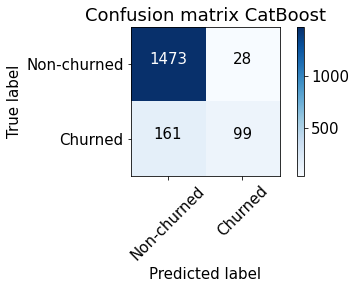

In [65]:
cnf_matrix = confusion_matrix(target_test, cb_predict)
#plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix CatBoost')
plt.savefig("conf_matrix.png")
plt.show()

Из 1761 случае:

* Модель в 1473 случае предсказал не отток клиенты и угадал

* Модель предсказали 28 не отток, но ошиблись в своём предсказании

* Модель предсказал 99 случай отток клиенты и угадали

* В 161 случае, модель предсказали отток клиенты, но ошиблись

**Важность признаков**

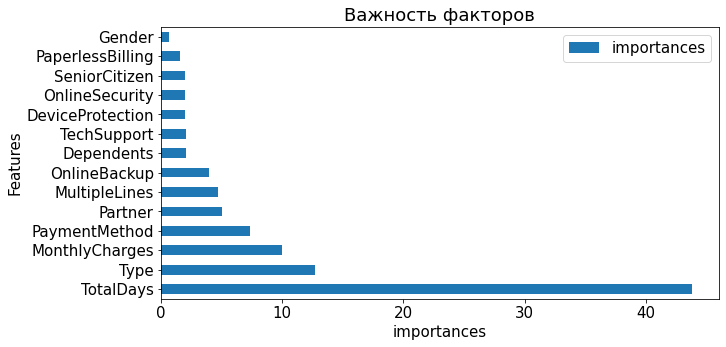

In [66]:
importances_df.plot(kind='barh', figsize=(10, 5), title='Важность факторов')

plt.xlabel("importances")
plt.ylabel("Features")

plt.show()

Достаточно логично, что на лояльность клиентов виляет время использования услуг(`TotalDays`). Как правило, чем дольше ты пользуешься услугами компании, тем меньше вероятность что ты от туда уйдешь. Признак `MonthlyCharges` - месячные траты и `Type` - типы оплаты, тоже достаточно логично, учитывая исследовательский анализ данных проведенных ранее. Затем идут признаки, отвечающие за срок договора, гендер и т.д.